# Introduction
Here, I import the raw matrices from the ADTs and export as a single object across all wells.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import sparse
import warnings
import itertools as it
import json
import seaborn as sns
import pickle as pkl
from functools import reduce
import gc
import timeit

from nero import Octavia
from nero import Nero as nr

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=30

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

## Load in the Data

In [4]:
wells = dict()
for well in range(12):
    wells[well] = dict()
    wells[well]['adata'] = sc.read_10x_h5(prefix_adts + "cr/well%d/outs/raw_feature_bc_matrix.h5" % (well + 1))
    wells[well]['adata'].var_names_make_unique()

reading /data/clue/prod/adts/cr/well1/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well2/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well3/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well4/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well5/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well6/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well7/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well8/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well9/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well10/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well11/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/clue/prod/adts/cr/well12/outs/raw_feature_bc_matrix.h5
 (0:00:07)


Also load in the barcodes from the mRNA, so I can subset and avoid having these giant matrices in memory, though they are sparse so it's not too bad.

In [5]:
path = prefix_mrna + 'vals/concat_bcs.txt'

with open(path,'r') as file:
    bcs = ['-'.join(i.strip().split('-')[:2]) for i in file.readlines()]

### Adjust Cell Barcodes

I'm adjusting the cell barcodes to make them match their well number, which I also did with the mRNA.

In [7]:
for well in tqdm(wells):
    wells[well]['adata'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata'].obs_names]

  0%|          | 0/12 [00:00<?, ?it/s]

Subsetting based on the mRNA barcodes.

In [8]:
for well in tqdm(wells):
    wells[well]['adata'] = wells[well]['adata'][[i for i in bcs if int(i.split('-')[-1]) == well]]

  0%|          | 0/12 [00:00<?, ?it/s]

Going to use the `filter_cells` and `filter_genes` functions just to get the `n_counts` column in the `.obs` and `.var`. Not actually filtering, since I'm setting my thresholds to 0.

In [12]:
for well in wells:
    sc.pp.filter_cells(wells[well]['adata'], min_counts=0)
    sc.pp.filter_genes(wells[well]['adata'], min_counts=0)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


# Concatenate

In [13]:
concat_adts = wells[0]['adata'].concatenate(*[wells[i]['adata'] for i in range(1,12)])

In [14]:
concat_adts.var['n_counts'] = concat_adts.var[[i for i in concat_adts.var.columns if i.startswith('n_counts')]].sum(axis=1)

# Filter Proteins

We often see that a few proteins have much lower counts than the rest. I remove those as they're usually not meaningful.

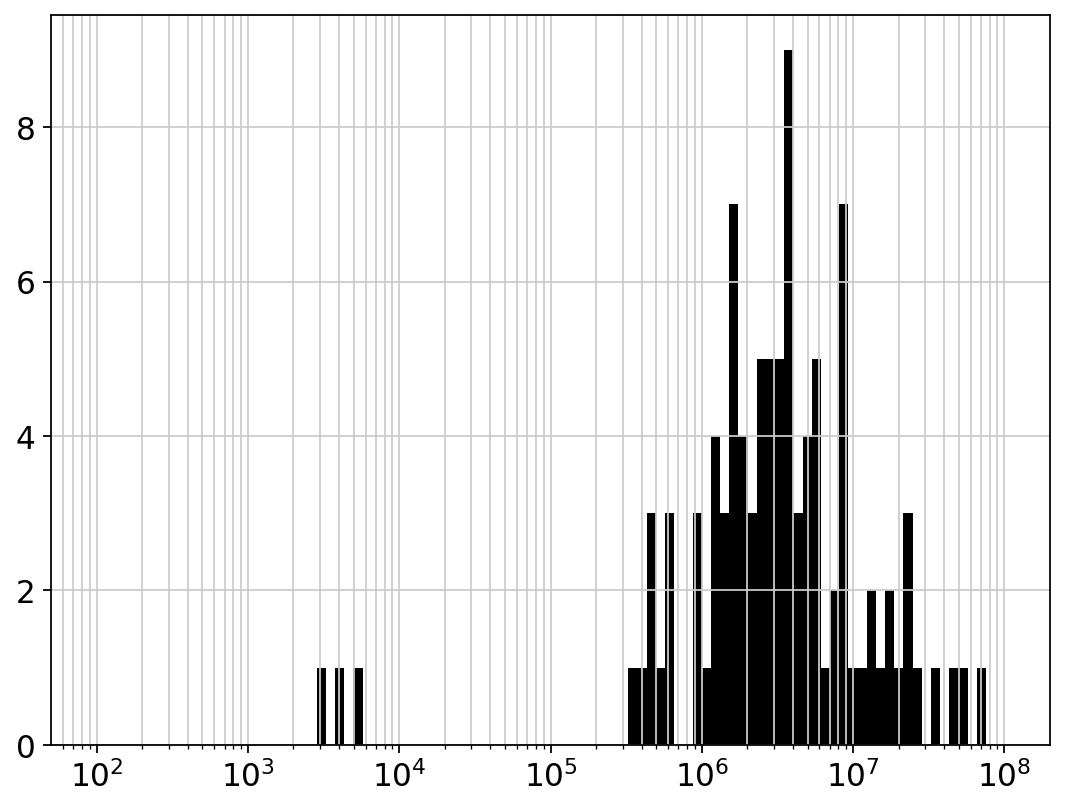

In [15]:
plt.figure(figsize=(8,6))
plt.hist(concat_adts.var['n_counts'].values, color='k', bins=np.logspace(np.log10(1e2),np.log10(1e8), 100))
plt.grid(False)
plt.grid(True, 'both', 'both')
plt.xscale('log')

Going to only keep those proteins with counts > 100K, since the ones below that are probably not real.

In [16]:
concat_adts = concat_adts[:,concat_adts.var['n_counts'] > 1e5].copy()

# Export

In [13]:
path = prefix + 'pkls/concat_adts.pkl'

# with open(path,'wb') as file:
#     pkl.dump(concat_adts, file)

with open(path,'rb') as file:
    concat_adts = pkl.load(file)